### Training the model

In [1]:
# Import dependencies
import torch
import random
import numpy as np
import matplotlib.pyplot as plt
from PIL import Image
from torch import nn, save, load
from torch.optim import Adam
from torch.utils.data import DataLoader
from torchvision import datasets
import torchvision.transforms as transforms
from torchsummary import summary

In [2]:
# Parameters
TRAINING_BATCH_SIZE = 100
NUM_EPOCHS = 10
LR = 1e-3
VAL_PERCENT = 0.2

CONV_C = 8
CONV_H = 5
CONV_W = CONV_H
CONV_STRIDE = 1

POOL_H = 2
POOL_W = 2
POOL_STRIDE = 2

CONV_LAYER_OUT_H = int((28 - CONV_H)/(CONV_STRIDE) + 1)
CONV_LAYER_OUT_W = int((28 - CONV_W)/(CONV_STRIDE) + 1)

POOL_OUT_H = int((CONV_LAYER_OUT_H - POOL_H)/(POOL_STRIDE) + 1)
POOL_OUT_W = int((CONV_LAYER_OUT_W - POOL_W)/(POOL_STRIDE) + 1)

FLATTEN_OUT_N = POOL_OUT_W * POOL_OUT_H * CONV_C
DENSE_N = 10


In [3]:
# Get data
train = datasets.MNIST(root="data", download=True, train=True, transform=transforms.Compose([transforms.ToTensor(), transforms.Normalize((0.1307,), (0.3081,))]))

val_size    = int(VAL_PERCENT * len(train))
train_size  = len(train) - val_size
train_dataset, val_dataset = torch.utils.data.random_split(train,[train_size, val_size])

train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=TRAINING_BATCH_SIZE, shuffle=True, pin_memory=True)
val_loader = torch.utils.data.DataLoader(val_dataset, batch_size=TRAINING_BATCH_SIZE, shuffle=False, pin_memory=True)

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
#1,28,28 - classes 0-9

Failed to download (trying next):
<urlopen error [SSL: CERTIFICATE_VERIFY_FAILED] certificate verify failed: certificate has expired (_ssl.c:1007)>



100%|██████████| 9.91M/9.91M [00:00<00:00, 17.6MB/s]


Extracting data/MNIST/raw/train-images-idx3-ubyte.gz to data/MNIST/raw

Failed to download (trying next):
<urlopen error [SSL: CERTIFICATE_VERIFY_FAILED] certificate verify failed: certificate has expired (_ssl.c:1007)>



100%|██████████| 28.9k/28.9k [00:00<00:00, 481kB/s]


Extracting data/MNIST/raw/train-labels-idx1-ubyte.gz to data/MNIST/raw

Failed to download (trying next):
<urlopen error [SSL: CERTIFICATE_VERIFY_FAILED] certificate verify failed: certificate has expired (_ssl.c:1007)>



100%|██████████| 1.65M/1.65M [00:00<00:00, 4.44MB/s]


Extracting data/MNIST/raw/t10k-images-idx3-ubyte.gz to data/MNIST/raw

Failed to download (trying next):
<urlopen error [SSL: CERTIFICATE_VERIFY_FAILED] certificate verify failed: certificate has expired (_ssl.c:1007)>



100%|██████████| 4.54k/4.54k [00:00<00:00, 3.79MB/s]

Extracting data/MNIST/raw/t10k-labels-idx1-ubyte.gz to data/MNIST/raw



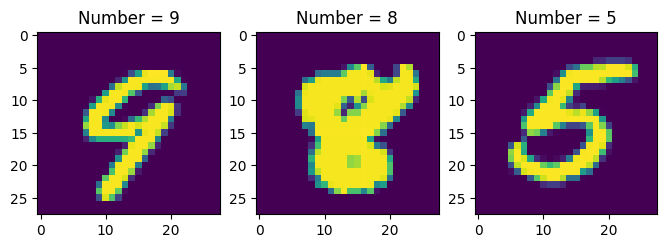

In [4]:
#Visualizing a few images
idx = random.randint(0,1000)
fig = plt.figure(figsize=(8, 8))
rows = 1
cols = 3
for i in range(1,rows*cols+1):
    fig.add_subplot(rows,cols,i)
    img, label = train[i+idx]
    plt.imshow(img[0])
    plt.title("Number = " + str(label))
plt.show()



In [5]:
# Image Classifier Neural Network
class ImageClassifier(nn.Module):
    def __init__(self):
        super().__init__()
        self.model = nn.Sequential(
            nn.Conv2d(1, CONV_C, (CONV_H, CONV_W)),
            nn.ReLU(),
            nn.MaxPool2d((POOL_H, POOL_W), POOL_STRIDE),
            nn.Flatten(),
            nn.Linear(POOL_OUT_H * POOL_OUT_W * CONV_C, 10)
        )

    def forward(self, x):
        return self.model(x)


In [6]:
#Probing model attributes
# help(ImageClassifier)

In [7]:
# Instance of the neural network, loss, optimizer
clf = ImageClassifier().to(device)
opt = Adam(clf.parameters(), lr=LR)
loss_fn = nn.CrossEntropyLoss()

summary(clf, (1,28,28))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1            [-1, 8, 24, 24]             208
              ReLU-2            [-1, 8, 24, 24]               0
         MaxPool2d-3            [-1, 8, 12, 12]               0
           Flatten-4                 [-1, 1152]               0
            Linear-5                   [-1, 10]          11,530
Total params: 11,738
Trainable params: 11,738
Non-trainable params: 0
----------------------------------------------------------------
Input size (MB): 0.00
Forward/backward pass size (MB): 0.09
Params size (MB): 0.04
Estimated Total Size (MB): 0.14
----------------------------------------------------------------


In [8]:
print(list(clf.model))

[Conv2d(1, 8, kernel_size=(5, 5), stride=(1, 1)), ReLU(), MaxPool2d(kernel_size=(2, 2), stride=2, padding=0, dilation=1, ceil_mode=False), Flatten(start_dim=1, end_dim=-1), Linear(in_features=1152, out_features=10, bias=True)]


In [9]:
# Training flow
losses = []
accuracies = []
val_losses = []
val_accuracies = []

for epoch in range(NUM_EPOCHS): # train for 10 epochs
    for batch in train_loader:
        X,y = batch
        X, y = X.to(device), y.to(device)
        yhat = clf(X)
        loss = loss_fn(yhat, y)

        # Apply backprop
        opt.zero_grad()
        loss.backward()
        opt.step()

    _, predicted = torch.max(yhat.data, 1)
    acc = (predicted == y).sum().item() / y.size(0)
    accuracies.append(acc)
    losses.append(loss.item())

    val_loss = 0.0
    val_acc = 0.0

    with torch.no_grad():
        for images, labels in val_loader:
            labels = labels.to(device)
            images = images.to(device)
            outputs = clf(images)
            loss = loss_fn(outputs, labels)
            val_loss += loss.item()

        _, predicted = torch.max(outputs.data, 1)
        total = labels.size(0)
        correct = (predicted == labels).sum().item()
        val_acc += correct / total
        val_accuracies.append(acc)
        val_losses.append(loss.item())

    print('Epoch [{}/{}],   Loss:{:.4f},    Val Loss:{:.4f},    Accuracy:{:.2f},    Val Accuracy:{:.2f}'.format(
        epoch+1, NUM_EPOCHS, loss.item(), val_loss, acc ,val_acc))

Epoch [1/10],   Loss:0.0607,    Val Loss:19.5034,    Accuracy:0.95,    Val Accuracy:0.99
Epoch [2/10],   Loss:0.0431,    Val Loss:10.7329,    Accuracy:0.95,    Val Accuracy:0.98
Epoch [3/10],   Loss:0.0354,    Val Loss:9.8908,    Accuracy:0.99,    Val Accuracy:0.98
Epoch [4/10],   Loss:0.0114,    Val Loss:7.8221,    Accuracy:1.00,    Val Accuracy:1.00
Epoch [5/10],   Loss:0.0288,    Val Loss:8.7709,    Accuracy:0.98,    Val Accuracy:0.99
Epoch [6/10],   Loss:0.0173,    Val Loss:8.0455,    Accuracy:0.98,    Val Accuracy:0.99
Epoch [7/10],   Loss:0.0267,    Val Loss:7.5561,    Accuracy:0.99,    Val Accuracy:1.00
Epoch [8/10],   Loss:0.0130,    Val Loss:6.8668,    Accuracy:0.98,    Val Accuracy:1.00
Epoch [9/10],   Loss:0.0080,    Val Loss:7.2533,    Accuracy:0.99,    Val Accuracy:1.00
Epoch [10/10],   Loss:0.0071,    Val Loss:6.5547,    Accuracy:0.99,    Val Accuracy:1.00


In [10]:
PATH = "model.pt"

torch.save({"model_state_dict":clf.state_dict()}, PATH)

### Saving intermediate values for random testbench

In [23]:
# get data
BATCH_SIZE = 5
NUM_CHANNELS = 1
IMG_HEIGHT = 28
IMG_WIDTH = 28

random_indices = [random.randint(0,59999) for _ in range(BATCH_SIZE)]
print(random_indices)


[6632, 1466, 54098, 57946, 17637]


In [24]:
# Extracting numpy arrays of data
sample_inp, sample_labels = [], []
for i in range(BATCH_SIZE):
    img, label = train[random_indices[i]]
    sample_inp.append(img)
    sample_labels.append(label)

sample_inp_tensor = torch.stack(sample_inp).to(device)
print("sample labels - ", sample_labels)

sample labels -  [3, 6, 9, 4, 1]


In [25]:
# define hooks
activation_dict = {}
def getActivation(name):
    def hook(model, input, output):
        activation_dict[name] = output.detach()
    return hook

h1 = clf.model[0].register_forward_hook(getActivation("Conv2d_out"))
h2 = clf.model[1].register_forward_hook(getActivation("Relu_out"))
h3 = clf.model[2].register_forward_hook(getActivation("Maxpool_out"))
h4 = clf.model[3].register_forward_hook(getActivation("Flatten_out"))
h5 = clf.model[4].register_forward_hook(getActivation("Dense_out"))


In [26]:
clf.eval()
with torch.no_grad():
    out_probs = clf(sample_inp_tensor)
    # print(out_probs)
    print(sample_labels)
    print(torch.argmax(out_probs, dim=1))


[3, 6, 9, 4, 1]
tensor([3, 6, 9, 4, 1], device='cuda:0')


In [27]:
print([(key,activation_dict[key].shape) for key in activation_dict.keys()])

h1.remove()
h2.remove()
h3.remove()
h4.remove()
h5.remove()

[('Conv2d_out', torch.Size([5, 8, 24, 24])), ('Relu_out', torch.Size([5, 8, 24, 24])), ('Maxpool_out', torch.Size([5, 8, 12, 12])), ('Flatten_out', torch.Size([5, 1152])), ('Dense_out', torch.Size([5, 10]))]


In [16]:
# print(activation_dict["Dense_out"][4])

### Exporting for fp adjustment

In [28]:
# WRITING IMG AND LABELS TO FILE
image_file = open('c_test_imgs.cpp', 'w')
label_file = open('c_test_label.cpp', 'w')

label_file.write("#define BATCH_SIZE {} \n".format(BATCH_SIZE))


image_file.write("#define BATCH_SIZE {} \n".format(BATCH_SIZE))
image_file.write("#define NUM_CHANNELS {} \n".format(NUM_CHANNELS))
image_file.write("#define IMG_HEIGHT {} \n".format(IMG_HEIGHT))
image_file.write("#define IMG_WIDTH {} \n".format(IMG_WIDTH))


label_file.write("const float test_labels[BATCH_SIZE] = { \n")

image_file.write("const float test_images[BATCH_SIZE * NUM_CHANNELS * IMG_HEIGHT * IMG_WIDTH] = { \n")

for i in range(BATCH_SIZE):
    img, label = sample_inp[i].data, sample_labels[i]

    label_file.write("{}, \n".format(label))
    image_file.write("\n \t \n") # img open brac

    num_channels, height, width = img.shape
    for i in range(num_channels):
        img_channel = img[i]
        image_file.write("\n \t\t \n") #channel open bracket

        # 784 vals in one line
        for j in range(height):
            for k in range(width):
                image_file.write("\t {}, ".format(img_channel[j][k]))

        image_file.write("\n \t\t \n") #channel close brac
    image_file.write("\n \t \n") #img close brac


label_file.write("};")

image_file.write("};")

label_file.close()
image_file.close()

In [29]:
# WRITE CONV_OUT FILE

current_layer_name = "Conv2d_out"
file = open("c_test_" + current_layer_name + ".cpp", 'w')


# file.write("#define BATCH_SIZE {} \n".format(BATCH_SIZE))
# file.write("#define NC {} \n".format(CONV_C))
# file.write("#define NH {} \n".format(CONV_LAYER_OUT_H))
# file.write("#define NW {} \n\n".format(CONV_LAYER_OUT_W))
file.write("#include \"../all_param_def.h\" \n")

file.write("const float conv_out[BATCH_SIZE * CONV_C * CONV_RES_H * CONV_RES_W] = { \n")

for i in range(BATCH_SIZE):
    file.write("\n \t \n")  # batch element open space

    for j in range(CONV_C):
        file.write("\n \t \n")      # conv channel element space

        # all 24*24 = 576 vals in one line
        for k in range(CONV_LAYER_OUT_H):
            for l in range(CONV_LAYER_OUT_W):
                file.write("\t {}, ".format(activation_dict[current_layer_name][i][j][k][l]))

    file.write("\n \t \n")  # batch close space

file.write("};")
file.close()

In [30]:
# WRITE RELU_OUT FILE

current_layer_name = "Relu_out"
file = open("c_test_" + current_layer_name + ".cpp", 'w')

# file.write("#define BATCH_SIZE {} \n".format(BATCH_SIZE))
# file.write("#define NC {} \n".format(CONV_C))
# file.write("#define NH {} \n".format(CONV_LAYER_OUT_H))
# file.write("#define NW {} \n\n".format(CONV_LAYER_OUT_W))
file.write("#include \"../all_param_def.h\" \n")

file.write("const float relu_out[BATCH_SIZE * CONV_C * CONV_RES_H * CONV_RES_W] = { \n")

for i in range(BATCH_SIZE):
    file.write("\n \t \n")  # batch element open space

    for j in range(CONV_C):
        file.write("\n \t \n")      # conv channel element space

        # all 24*24 = 576 vals in one line
        for k in range(CONV_LAYER_OUT_H):
            for l in range(CONV_LAYER_OUT_W):
                file.write("\t {}, ".format(activation_dict[current_layer_name][i][j][k][l]))

    file.write("\n \t \n")  # batch close space

file.write("};")
file.close()

In [31]:
# WRITE MAXPOOL_OUT FILE

current_layer_name = "Maxpool_out"
file = open("c_test_" + current_layer_name + ".cpp", 'w')


# file.write("#define BATCH_SIZE {} \n".format(BATCH_SIZE))
# file.write("#define NC {} \n".format(CONV_C))
# file.write("#define NH {} \n".format(POOL_OUT_H))
# file.write("#define NW {} \n\n".format(POOL_OUT_W))
file.write("#include \"../all_param_def.h\" \n")

file.write("const float mxp_out[BATCH_SIZE * CONV_C * POOL_RES_H * POOL_RES_W] = { \n")

for i in range(BATCH_SIZE):
    file.write("\n \t \n")  # batch element open space

    for j in range(CONV_C):
        file.write("\n \t \n")      # conv channel element space

        # all 24*24 = 576 vals in one line
        for k in range(POOL_OUT_H):
            for l in range(POOL_OUT_W):
                file.write("\t {}, ".format(activation_dict[current_layer_name][i][j][k][l]))

    file.write("\n \t \n")  # batch close space

file.write("};")
file.close()

In [32]:
# WRITE FLATTEN_OUT FILE

current_layer_name = "Flatten_out"
file = open("c_test_" + current_layer_name + ".cpp", 'w')

# file.write("#define BATCH_SIZE {} \n".format(BATCH_SIZE))
# file.write("#define N {} \n".format(FLATTEN_OUT_N))
file.write("#include \"../all_param_def.h\" \n")

file.write("const float flt_out[BATCH_SIZE * DENSE_WEIGHTS_W] = { \n")

for i in range(BATCH_SIZE):
    file.write("\n \t \n")  # batch element open space

    for j in range(FLATTEN_OUT_N):
        file.write("\t {}, ".format(activation_dict[current_layer_name][i][j]))

    file.write("\n \t \n")  # batch close space

file.write("};")
file.close()

In [33]:
# WRITE DENSE_OUT FILE

current_layer_name = "Dense_out"
file = open("c_test_" + current_layer_name + ".cpp", 'w')

# file.write("#define BATCH_SIZE {} \n".format(BATCH_SIZE))
# file.write("#define N {} \n".format(DENSE_N))
file.write("#include \"../all_param_def.h\" \n")

file.write("const float dense_out[BATCH_SIZE * DENSE_WEIGHTS_H] = { \n")

for i in range(BATCH_SIZE):
    file.write("\n \t \n")  # batch element open space

    for j in range(DENSE_N):
        file.write("\t {}, ".format(activation_dict[current_layer_name][i][j]))

    file.write("\n \t \n")  # batch close space

file.write("};")
file.close()